# 5. Compare with immunnobuilder

## Install ImunnoBuilder

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [ ]:
!conda install -c conda-forge openmm pdbfixer

In [ ]:
# install anarci
conda install -c conda-forge biopython -y
conda install -c bioconda hmmer=3.3.2 -y
cd ANARCI
python setup.py install

In [116]:
!pip install ImmuneBuilder

^C


In [79]:
import ImmuneBuilder
ImmuneBuilder.__file__

'/Users/rbeno/anaconda3/envs/mamba/lib/python3.10/site-packages/ImmuneBuilder/__init__.py'

----

## Setup

In [7]:
import sys
sys.path.append('../..')
import collections
import pandas as pd
import os
import pickle
import re
import seaborn as sns
import time
import numpy as np
import bin.params as p
import bin.utils as u
import bin.feature_generators as fg

from tqdm.notebook import tqdm
from ImmuneBuilder import ABodyBuilder2
from biopandas.pdb import PandasPdb
from Bio.PDB import PDBParser, PPBuilder

sns.set_theme()

In [17]:
# old
IB_PREDS_DIR = f'{p.DATA_DIR}/pdb/immunobuilder_{p.FINAL_NUMBERING_SCHEME}' # old

# july2024
IB_PREDS_DIR = f'{p.DATA_DIR}/pdb/immunobuilderJuly2024_{p.FINAL_NUMBERING_SCHEME}' # output_dor
IB_INPUT_PDB_DIR = f'{p.DATA_DIR}/pdb/incrementalJuly2024' # input sequences for immunebuilder predictions
IB_PREDICTION_STATUS_PATH = f'{p.DATA_DIR}/csv/ib_predictions_{p.FINAL_NUMBERING_SCHEME}.csv'
# IB_PRED_TIME_VS_AVG_SEQ_LEN_SCATTEPLOT_PNG = f'{p.DATA_DIR}/png/ib_predictions_{p.FINAL_NUMBERING_SCHEME}_predtime_vs_avglen.png'
# IB_PRED_TIME_VS_AVG_SEQ_LEN_SCATTEPLOT_PNG = f'{p.DATA_DIR}/png/ib_predictions_{p.FINAL_NUMBERING_SCHEME}_predtime_vs_avglen2.png'
IB_PRED_TIME_VS_AVG_SEQ_LEN_SCATTEPLOT_PNG = f'{p.DATA_DIR}/png/ib_predictions_{p.FINAL_NUMBERING_SCHEME}_predtime_vs_avglen3.png'

# just a template - does not matter much which particular CSV we will use
IB_PREDS_FINAL_TEMPLATE_CSV_PATH = f'{IB_PREDS_FINAL_CSV_DIR}/lco_cont_window_r2_all_H_randomForestN5.csv'

# common
DATASET = 'test_new_234'
IB_PREDS_FINAL_CSV_DIR = f'{p.DATA_DIR}/csv/test/predictions'
DL_SEQS_OVER_DL_LIMIT_TESTNEW_L = f'{p.DATA_DIR}/csv/dl_guard/dl_{DATASET}_l.csv'
DL_SEQS_OVER_DL_LIMIT_TESTNEW_H = f'{p.DATA_DIR}/csv/dl_guard/dl_{DATASET}.csv' # empty for now, great!
IB_PRED2_LEN_DIFF_HIST_PNG = f'{p.DATA_DIR}/png/ib_pred2_{DATASET}_len_diff_hist.png' # empty for now, great!
IB_PRED3_LEN_DIFF_HIST_PNG = f'{p.DATA_DIR}/png/ib_pred3_{DATASET}_len_diff_hist.png' # empty for now, great!
CHAIN_DICTS_PICKLE_FILE_PATH = f'{p.DATA_DIR}/pickles/ib_chains_{DATASET}.p'

(IB_INPUT_PDB_DIR,
 IB_PREDICTION_STATUS_PATH, IB_PRED_TIME_VS_AVG_SEQ_LEN_SCATTEPLOT_PNG, IB_PREDS_DIR, 
 IB_PREDS_FINAL_CSV_DIR, IB_PREDS_FINAL_TEMPLATE_CSV_PATH,
 DL_SEQS_OVER_DL_LIMIT_TESTNEW_L, DL_SEQS_OVER_DL_LIMIT_TESTNEW_H,
 IB_PRED2_LEN_DIFF_HIST_PNG,
 IB_PRED_TIME_VS_AVG_SEQ_LEN_SCATTEPLOT_PNG,
 CHAIN_DICTS_PICKLE_FILE_PATH
)

('../../data/pdb/incrementalJuly2024',
 '../../data/csv/ib_predictions_aho.csv',
 '../../data/png/ib_predictions_aho_predtime_vs_avglen3.png',
 '../../data/pdb/immunobuilderJuly2024_aho',
 '../../data/csv/test/predictions',
 '../../data/csv/test/predictions/lco_cont_window_r2_all_H_randomForestN5.csv',
 '../../data/csv/dl_guard/dl_test_new_234_l.csv',
 '../../data/csv/dl_guard/dl_test_new_234.csv',
 '../../data/png/ib_pred2_test_new_234_len_diff_hist.png',
 '../../data/png/ib_predictions_aho_predtime_vs_avglen3.png',
 '../../data/pickles/ib_chains_test_new_234.p')

In [13]:
command = f'mkdir -p {IB_PREDS_DIR}'
print('ib preds dir:', IB_PREDS_DIR)
! $command

ib preds dir: ../../data/pdb/immunobuilderJuly2024_aho


----

### OLD (DEPRECATED) RETRIEVAL OF SABDAB STRUCTURES

In [3]:
# old code

In [67]:
# go through summary TSV file downloaded from sabdab on 14th July 2024
summary_2024_df = pd.read_csv(f"{p.DATA_DIR}/pdb/all_structures_2024/sabdab_summary_all.tsv", sep='\t')
summary_2024_df['year'] = summary_2024_df.apply(lambda row: row['date'].split('/')[-1], axis=1) # extract last two digits from date
summary_2024_df.head()

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid,year
0,8pn0,A,B,0,F | E,protein | protein,NA | NA,capsid protein | capsid protein,VIRAL PROTEIN,01/08/09,...,True,IGHV1,IGLV2,Lambda,None,None,None,None,None,09
1,8pn0,H,L,0,D | C,protein | protein,NA | NA,capsid protein | capsid protein,VIRAL PROTEIN,01/08/09,...,True,IGHV1,IGLV2,Lambda,None,None,None,None,None,09
2,8jza,A,NaN,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,07/10/24,...,True,unknown,unknown,unknown,None,None,None,None,None,24
3,8p2t,H,L,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,07/10/24,...,True,IGHV1,IGLV1,Lambda,None,None,None,None,None,24
4,8p6h,H,L,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,07/10/24,...,True,IGHV1,IGLV1,Lambda,None,None,None,None,None,24


In [68]:
# show weird resolutions
resolutions = list(summary_2024_df['resolution'].unique())
for r in resolutions:
    try:
        fr = float(r)
    except:
        print(r)

NOT
3.9, 3.9
8.9, 8.9


In [69]:
MAX_RES = 10
def normalize_res(res):
    if res == 'NOT':
        res = MAX_RES
    elif ' ' in res:
       tokens = re.split('\D+', res)
       res = tokens[0]
    res = float(res)
    return res

# no errors here, i hope, otherwise the function is bad
for r in resolutions:
    float(normalize_res(r))

In [70]:
ACCEPTABLE_YEARS = ('22', '23', '24')
def filter_bad_structure(row):
    if row['year'] not in ACCEPTABLE_YEARS:
        # structure too old, included in the training set
        return False
    if normalize_res(row['resolution']) > p.RESOLUTION_CUTOFF:
        # resolution is too bad (high)
        return False
    return True

In [114]:
# extract the new ones into new DF and make group by year
new_structures_mask = summary_2024_df.apply(filter_bad_structure, axis=1)
new_structures_df = summary_2024_df[new_structures_mask]
new_structures_df.head()

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid,year
2,8jza,A,NaN,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,07/10/24,...,True,unknown,unknown,unknown,None,None,None,None,None,24
3,8p2t,H,L,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,07/10/24,...,True,IGHV1,IGLV1,Lambda,None,None,None,None,None,24
4,8p6h,H,L,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,07/10/24,...,True,IGHV1,IGLV1,Lambda,None,None,None,None,None,24
6,8pmz,B,b,0,A,protein,NaN,pro-secreted protein orf2,VIRAL PROTEIN,07/10/24,...,True,unknown,unknown,unknown,None,None,None,None,None,24
7,8pmz,D,d,0,C,protein,NaN,pro-secreted protein orf2,VIRAL PROTEIN,07/10/24,...,True,unknown,unknown,unknown,None,None,None,None,None,24


In [88]:
new_structures_df.shape

(2862, 31)

In [89]:
new_structures_df.to_csv(f"{p.DATA_DIR}/csv/2024_new_structures.csv")

In [102]:
all_pdbs = set(summary_2024_df['pdb'])
good_pdbs = set(new_structures_df['pdb'])
len(all_pdbs), len(good_pdbs)

(8669, 1524)

In [103]:
len(summary_2024_df['pdb'].unique())

8669

In [104]:
bad_pdbs = all_pdbs.difference(good_pdbs)
len(bad_pdbs)

7145

In [105]:
# remove PDB files that do not meet the criteria from the folder
removals = []
for structure in bad_pdbs:
    path = f"{p.DATA_DIR}/pdb/all_structures_2024/{p.INITIAL_NUMBERING_SCHEME}/{structure}.pdb"
    if os.path.exists(path):
        os.remove(path)
        removals.append(structure)
len(removals)

0

In [112]:
# sanity-check that the good structures remained there
good, bad = 0, 0
for s in good_pdbs:
    path = f"{p.DATA_DIR}/pdb/all_structures_2024/{p.INITIAL_NUMBERING_SCHEME}/{s}.pdb"
    if os.path.exists(path):
        good += 1
    else:
        bad += 1
good, bad

(1524, 0)

----

### OTHER OLD CODE

In [33]:
# method 1 to fill the chain_dicts
# from the final results of the pipeline
# old
chain_dicts = collections.defaultdict(dict)
for dat in [('L', X_orig_L), ('H', X_orig_H)]:
    chain, df = dat
    sequences = df.apply(lambda row: ''.join(row.astype(str)), axis=1)
    for row in sequences:
        structure_name = row[:4]
        aa_sequence = row[6:].replace('-', '')
        chain_dicts[structure_name][chain] = aa_sequence
        assert chain == row[5]
len(chain_dicts), len(X_orig_L), len(X_orig_H)

(888, 888, 888)

In [96]:
# IB_PREDS_DIR = f'{p.DATA_DIR}/pdb/immunobuilderJuly2024_{p.FINAL_NUMBERING_SCHEME}' # july2024 test_new_234
IB_NUMBERING_SCHEME = 'raw'
IB_PREDS_DIR = f'{p.DATA_DIR}/pdb/immunobuilder3July2024_{IB_NUMBERING_SCHEME}' # july2024 test_new_234
print(IB_PREDS_DIR)
command = f"mkdir -p {IB_PREDS_DIR}"
! $command

../../data/pdb/immunobuilder3July2024_raw


----

### PREDICTION GENERATION

In [86]:
# load the test dataset
X_orig_L, Y_orig_L = u.load_dataset('test_new_234', 'L', options={'avoid_dl_removal': True})
X_orig_H, Y_orig_H = u.load_dataset('test_new_234', 'H', options={'avoid_dl_removal': True})

load_dataset: test_new_234, metadata file path: ../../data/csv/metadataJuly2024/metadata_L.csv, chains: L, shape: (888, 19)
load_dataset: test_new_234, X file path: ../../data/csv/fasta_aligned_cleaned_finJuly2024/fasta_aho_L.csv, chains: L, shape: (888, 154)
load_dataset: test_new_234, Y file path: ../../data/csv/sasa_aligned_finJuly2024/sasa_L.csv, chains: L, shape: (888, 154)
load_dataset: test_new_234, metadata file path: ../../data/csv/metadataJuly2024/metadata_H.csv, chains: H, shape: (888, 19)
load_dataset: test_new_234, X file path: ../../data/csv/fasta_aligned_cleaned_finJuly2024/fasta_aho_H.csv, chains: H, shape: (888, 165)
load_dataset: test_new_234, Y file path: ../../data/csv/sasa_aligned_finJuly2024/sasa_H.csv, chains: H, shape: (888, 165)


In [87]:
X_orig_L.head(n=1)

,Id,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,7DF1:L,D,I,V,M,T,Q,S,P,D,...,G,Q,G,T,R,L,E,I,-,-


In [88]:
X_orig_H.head(n=1)

,Id,1,2,3,4,5,6,7,8,9,...,141,142,143,143A,144,145,146,147,148,149
0,7DF1:H,-,V,Q,L,V,Q,S,-,G,...,Q,G,T,-,M,V,T,V,S,-


In [89]:
Y_orig_L.head(n=1)

,Id,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,7DF1:L,74.7,3.9,78.1,0.0,75.8,0.0,78.1,41.7,87.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Fill in the chain dicts: (method 2)**

In [15]:
def extract_chain_sequences(pdb_file):
    parser = PDBParser()
    structure = parser.get_structure('structure', pdb_file)
    ppb = PPBuilder()
    sequences = {}

    for model in structure:
        for chain in model:
            chain_id = chain.get_id()
            sequence = ''.join([str(pp.get_sequence()) for pp in ppb.build_peptides(chain)])
            sequences[chain_id] = sequence
    return sequences

In [21]:
# IB_INPUT_PDB_DIR = f'{p.DATA_DIR}/pdb/all_structures_2024/{p.INITIAL_NUMBERING_SCHEME}' # old
print('Input for IB', IB_INPUT_PDB_DIR)
files = [x for x in os.listdir(IB_INPUT_PDB_DIR) if x.endswith('.pdb')]
chain_dicts = collections.defaultdict(dict)

for file in tqdm(files, 'Collecting sequences Method#2...'):
    pdb_code = file.replace(".pdb", "")[-4:].upper()
    complete_path = f"{IB_INPUT_PDB_DIR}/{file}"
    chain_dicts[pdb_code] = extract_chain_sequences(complete_path)
    
with open(CHAIN_DICTS_PICKLE_FILE_PATH, 'wb') as pickle_file:
    print('pickled to:', )
    pickle.dump(chain_dicts, pickle_file)

Input for IB ../../data/pdb/incrementalJuly2024


pickled to:


In [22]:
with open(CHAIN_DICTS_PICKLE_FILE_PATH, 'rb') as pickle_file:
    chain_dicts = pickle.load(pickle_file)

In [6]:
# 167 light chains were removed due to them being too similar to sequences that the IB-was trained-on.
# IB requires a full chain pairs. We need to handle removal of leaking Ls later.

In [23]:
chain_dicts['7Z0Y']

{'H': 'VQLVESGGGVVQPGRSLRLSCAASGFTFSNYAIHWVRQAPGKGLEWVAVVSYDGSNKYYAESVKGRFTISRDNSKNTLSLQMISLRPEDTAVYYCASVADTAMVPEWYFDLWGQGTMVTVSSASTKGPSVFPLAPSSGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPK',
 'L': 'SVLTQPRSVSGSPGQSVTISCTGTSSDVGAYNYVSWYQQHPGKAPKLMIYDVSARPSGVPDRFSGSKSGNTASLTISGLQAEDEADYYCCSYAGSWVFGGGTKLTVLGQPKAAPSVTLFPPSSEELQANKATLVCLISDFYPGAVTVAWKADSSPVKAGVETTTPSKQSNNKYAASSYLSLTPEQWKSHRSYSCQVTHEGSTVEKTVAPTE'}

In [25]:
incomplete_structures, complete_structures = [], []
for structure, sequences in chain_dicts.items():
    if 'L' not in sequences or 'H' not in sequences:
        incomplete_structures.append(structure)
    else: 
        complete_structures.append(structure)
print('#-of-incompletes:', len(incomplete_structures), 'incompletes:', incomplete_structures)
print('#-of-completes:', len(complete_structures))
assert len(incomplete_structures) == 0

#-of-incompletes: 0 incompletes: []
#-of-completes: 888


In [97]:
times = dict()
errors = []

#predictor = ABodyBuilder2(numbering_scheme=IB_NUMBERING_SCHEME)
predictor = ABodyBuilder2(numbering_scheme=p.FINAL_NUMBERING_SCHEME)
structure_items = list(chain_dicts.items())
for structure, sequences in tqdm(structure_items, desc='Predicting structures with ImmuneBuilder'):
    start_time = time.time()
    output_file = f"{IB_PREDS_DIR}/{structure}.pdb"
    #if os.path.exists(output_file):
    #    print(structure, 'skipped - computed already')
    #    continue
    try:
        antibody = predictor.predict(sequences)
        antibody.save(output_file)
        end_time = time.time()
        time_diff = end_time - start_time
        times[structure] = time_diff
        print(structure, 'done', time_diff)
    except Exception as e:
        print(structure, e)
        errors.append({'structure': structure, 'error': e})

Predicting structures with ImmuneBuilder:   0%|          | 0/888 [00:00<?, ?it/s]

8QH0 done 4.7016379833221436
8DS5 done 4.721930980682373
8HEC done 4.997770071029663
7UL1 done 4.9182891845703125
8XN9 done 5.516834259033203
7UVI done 7.493820905685425
8OXX done 4.828150033950806
8DIM done 4.284628868103027
8DKE done 4.102043151855469
8SDG done 5.072592735290527
8HPU done 12.727066040039062
7XDA done 4.912117004394531
8E8Y done 4.751289129257202
8UKY done 4.685089111328125
7X08 Sequence missing too many residues to model correctly. Please give whole sequence:
QIQPGGSLRLSCAASGFSFISNYMSWVRQAPGKGLEWVSVIYSGGSTFYADSVKGRFTISRDKSKNTLYLQMNSLRAEDTAFYYCARGLIRGIIMTGAFDIWDEGTMVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKS
8U08 done 5.326909065246582
8IUY done 4.262417793273926
7QT3 done 5.2011237144470215
7Z3W done 4.823630094528198
7THO done 4.449362277984619
8IB1 done 5.015804767608643
8BSE done 4.934481859207153
8GAS done 4.4737958908081055
7XRZ done 4.249409914016724
8EUU done 4.384567022323608
7TJQ done 4.37785911

In [58]:
for error in errors: print(error['structure'])

7X08
7UL3
8DGV
8IV0
8G2M
8SVE
7YAR
8HHY
8VZO


In [98]:
IB_PREDS_DIR

'../../data/pdb/immunobuilder3July2024_raw'

In [99]:
# add HEADER lines
print(IB_PREDS_DIR)
PREFIX = 'HEADER    UNKNOWN EXPERIMENT                      UNKNOWN     PDB_CODE\n'
files = tqdm([f for f in os.listdir(IB_PREDS_DIR) if f.endswith('.pdb')], desc='Adding HEADER lines to PDB files...')
for filename in files:
    pdb_code = filename.replace('.pdb', '')[-4:]
    print(pdb_code)
    file_content = None
    fp = f"{IB_PREDS_DIR}/{filename}"
    with open(fp, 'r') as f:
        file_content = f.read()
    with open(fp, 'w') as f:
        f.write(PREFIX.replace('PDB_CODE', pdb_code) + file_content)

../../data/pdb/immunobuilder3July2024_raw


Adding HEADER lines to PDB files...:   0%|          | 0/879 [00:00<?, ?it/s]

8QH0
8DS5
8HEC
7UL1
8XN9
7UVI
8OXX
8DIM
8DKE
8SDG
8HPU
7XDA
8E8Y
8UKY
8U08
8IUY
7QT3
7Z3W
7THO
8IB1
8BSE
8GAS
7XRZ
8EUU
7TJQ
7QT2
7ZQT
8GY5
8E8X
8SDF
8CBZ
7WCK
8DF5
8OXY
7UVH
7U64
7RE9
8A99
8CT6
7UL0
8TUI
8HEB
8QH1
7WWL
8TV1
7U9O
8SSZ
8ACI
7YV1
8SIT
8AWL
8VUI
8SIC
7WN8
8DKF
8HPV
7WBZ
8CBX
8T7I
7TR4
7XDB
7STS
8IUZ
8GZZ
8EUW
7QT0
8BSF
7Z0X
8P6I
7T3M
8P6H
8G4M
7TD8
8EZ8
8G8N
7Z0Y
7SL5
8EUV
8BF0
7STR
8EOO
7XEG
8CBY
8D1T
8HRH
8C67
8D01
8D29
8SGI
8V4F
8FG0
8CW9
8FJA
8DPM
8DS7
7WVI
7WUR
7WWM
7WWI
8CWK
7UM3
7U63
7UCY
8DJG
8JEP
8SIQ
7UVO
8C7V
8CAF
8DGW
7WBH
7SUE
8ELP
8UIW
8U32
7VGS
7QU1
8G9Y
8GBY
8GB8
7T17
7SA6
7XS8
8GAT
7SBZ
8GBX
8G9X
7QT4
8BG1
7VGR
8GYE
7X1M
8ELQ
8R8D
8BK2
8RMO
7X2A
8TBQ
8HQ7
8T6I
8SH5
8TLM
8SIP
8SJK
8JEQ
8TZW
7UAP
8FDO
7U62
8XNH
7UCX
7WVL
8HED
8CWJ
8HES
8HGL
8FHY
7WTF
7WWJ
8FFE
7U60
8OL9
8F38
8DK6
8DKW
8FR6
7WLW
7UZ9
8SEF
8T51
8DFG
8SGN
8HRX
8EL2
7X25
8U31
7SX7
8U2C
7XJ9
7ZF8
7QU2
8GBZ
7T0F
8GAV
7XJ8
7VEN
8WSN
7ST5
7SWX
8HPF
8DGU
8SGO
8HPQ
8TCA
7UZ8
7UT3
8DK7
8SID
8VVB
8AV9


In [100]:
len(times), len(errors)

(879, 9)

In [101]:
errors

[{'structure': '7X08',
  'error': AssertionError('Sequence missing too many residues to model correctly. Please give whole sequence:\nQIQPGGSLRLSCAASGFSFISNYMSWVRQAPGKGLEWVSVIYSGGSTFYADSVKGRFTISRDKSKNTLYLQMNSLRAEDTAFYYCARGLIRGIIMTGAFDIWDEGTMVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKS')},
 {'structure': '7UL3',
  'error': AssertionError('Sequence missing too many residues to model correctly. Please give whole sequence:\nTQSSLSASVGDRTITCRASSAVAWYQQKPGKAPKLLIYSASSLYSGVPSRFSGSRGTDFTLTISSLQPEDFATYYCQQSSSSLITFGQGTKVEIKRTVAAPSVFIFPPSDSQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNR')},
 {'structure': '8DGV',
  'error': AssertionError('Sequence missing too many residues to model correctly. Please give whole sequence:\nPGTLSLSAGERATLSCRASQTMTKNYVAWYQQKPGQAPRLLIYGASTRATGIPDRFSGSGSGTDFTLTISRLAPEDFAVYYCLQYGSSPPIFTFGPGTKVEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTL

In [102]:
import pandas as pd
ib_input_df = pd.DataFrame({
    'structure': times.keys(),
    'avg_len': [(len(chain_dicts[s]['L'])+len(chain_dicts[s]['H'])) / 2.0 for s in times.keys()], 
                         'ib_time': times.values(),
                          'L': [chain_dicts[s]['L'] for s in times.keys()],
                          'H': [chain_dicts[s]['H'] for s in times.keys()],
                          'len_L': [len(chain_dicts[s]['L']) for s in times.keys()],
                          'len_H': [len(chain_dicts[s]['H']) for s in times.keys()]
})
ib_input_df['len_diff(L-H)'] = ib_input_df['len_L'] - ib_input_df['len_H']
print('ib_input_df.shape', ib_input_df.shape)
ib_input_df.to_csv(IB_PREDICTION_STATUS_PATH)

ib_input_df.shape (879, 8)


In [4]:
ib_input_df = pd.read_csv(IB_PREDICTION_STATUS_PATH, index_col=0)
print('ib_input_df shape', ib_input_df.shape)
ib_input_df.head(n=1)

ib_input_df shape (879, 8)


,structure,avg_len,ib_time,L,H,len_L,len_H,len_diff(L-H)
0,8QH0,212.0,4.701638,IVLTQSPGTLSLSPGERATLSCRASQSVSSSYLAWYQQKPGQAPRL...,EVQLVESGGGLIQPGGSLRLSCAASGITVTSNYMSWVRQAPGKGLE...,209,215,-6


In [6]:
ib_input_df['ib_time'].sum()

4674.25922036171

In [5]:
ib_input_df['ib_time'].describe()

count    879.000000
mean       5.317701
std        2.690669
min        3.724147
25%        4.464541
50%        4.765099
75%        5.228972
max       38.426016
Name: ib_time, dtype: float64

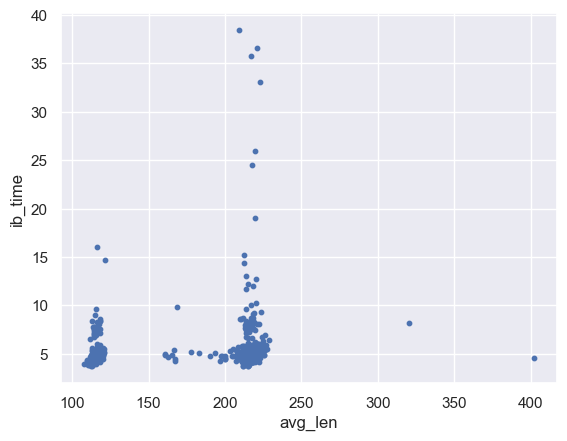

In [104]:
ib_time_vs_avg_len_plot = ib_input_df.plot.scatter(x='avg_len', y='ib_time', s=10)
ib_time_vs_avg_len_plot.figure.savefig(IB_PRED_TIME_VS_AVG_SEQ_LEN_SCATTEPLOT_PNG)

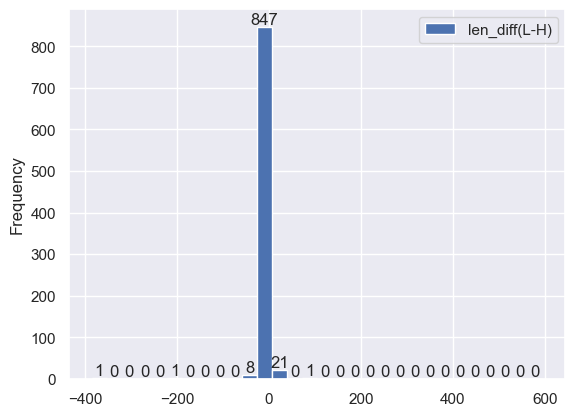

In [108]:
len_diff_hist = ib_input_df.plot.hist(column='len_diff(L-H)', bins=30)
for i in len_diff_hist.containers: len_diff_hist.bar_label(i,) # display numerical values at the top of bars
len_diff_hist.figure.savefig(IB_PRED3_LEN_DIFF_HIST_PNG)

In [110]:
print('len_diff[L-h].mean()', ib_input_df['len_diff(L-H)'].mean(), '| len_L.mean()', 
      ib_input_df['len_L'].mean(), '| len_H.mean()', ib_input_df['len_H'].mean())

len_diff[L-h].mean() -8.936291240045506 | len_L.mean() 183.4869169510808 | len_H.mean() 192.4232081911263


### Playground

In [1]:
import sys
sys.path.append('../..')
import os
import pickle
import pandas as pd
import numpy as np
import bin.utils as u
import bin.feature_generators as fg
import bin.params as p
from biopandas.pdb import PandasPdb

IMMUNOBUILDER_DIR = '../../data/csv/immunobuilder'

In [14]:
seqs_not_processed = ['6VZI', '6W03', '6WIX', '6XLI', '7E7X', '7KZC', '7PC2', '7X08']
ib_preds_df = pd.read_csv('../../data/csv/ib_input.csv', index_col=0)
ib_preds_df

,structure,avg_len,ib_time,L,H
0,6LCS,113.5,1438.779332,DIELTQSPAIMSASLGEQVTMTCTASSSVSSSYLHWYQQKPGSSPK...,VKLQQSGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKFEY...
1,6LDV,113.0,6.763050,AQGLTQTPSPVSAALGGTVTINCQSSQSVYGNNRLAWYQQKPGQPP...,QSVEESGGRLVTPGTPLTLTCTVSGFSLNSNAISWVRQAPGEGLEW...
2,6LDW,111.0,6.396037,QVLTQTPSSVSAAVGGTVTINCQASQSVYNNNWLGWYQQKPGQPPK...,QSVEESGGRLVTPGTPLTLTCTVSGFSLTSYDMSWVRQAPGKGLEY...
3,6LDX,113.0,5.476944,DPVMTQTPPSVSAAVGGTVTISCQSSQSVYNNDNLAWYQQKPGQPP...,DQSLEESGGRLVTPGTPLTLTCTVSGFSLNNNAMGWFRQAPGEGLE...
4,6LDY,113.5,5.298874,ALVLTQTPSPVSAAVGGAVSISCQSSQNIYKDNELSWYQQKPGQPP...,QTVKESGGRLVTPGGTLTLTCTVSGFSLSRYAMSWVRQAPGEGLEY...
...,...,...,...,...,...
630,7WPV,117.5,8.818904,VVTQPASVSGSPGQSITISCTGTSSDIGAYNYISWYQQHPGKAPKL...,EVQLQQSGPGLVKPSQTLSLTCAISGDSVSSNSAAWNWIRQSPSRG...
631,7WRV,114.0,5.082723,DIQMTQSPSSLSASVGDRVTITCRASQGISSWLAWYQQKPGKAPKL...,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...
632,7X9E,113.5,5.408550,ALTQPLSVSGSPGQSVTISCTGSSSDIGSYNFVSWYRQYPGKAPKV...,VQLVESGGGVVQPGGSLRLSCEASGFSFKDYGMHWIRQTPGLEWIS...
633,7Z0X,119.0,6.475814,SYELTQPASVSGSPGQSITISCTGTSSDVGSYNLVSWYQQHPGKAP...,EVQLVESGGGLVQPGGSLRLSCAASGFTVSSNYMSWVRQAPGKGLE...


In [3]:
preds_path = f'{p.DATA_DIR}/csv/test/predictions/lco_cont_window_r2_all_H_randomForestN5.csv'
preds_df = pd.read_csv(preds_path, index_col=0).set_index(['sequence_id', 'position'])
preds_df['prediction'] = np.nan
preds_df

,,prediction
sequence_id,position,
6LCS:H,1,NaN
6LDV:H,1,NaN
6LDW:H,1,NaN
6LDX:H,1,NaN
6LDY:H,1,NaN
...,...,...
7WRV:H,149,NaN
7X08:H,149,NaN
7X9E:H,149,NaN


In [4]:
structure = '7CHB'
ppdb = PandasPdb()
ppdb.read_pdb(f"{IMMUNOBUILDER_DIR}/{structure}.pdb")

In [92]:
ppdb_l_df = ppdb.df["ATOM"][ppdb.df["ATOM"]["chain_id"] == "L"]
ppdb_l_df

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
1729,ATOM,1731,,N,,ILE,,L,2,,...,6.472,3.438,15.189,1.0,0.38,,,N,NaN,1732
1730,ATOM,1732,,H,,ILE,,L,2,,...,6.277,3.879,14.299,1.0,0.38,,,H,NaN,1733
1731,ATOM,1733,,H2,,ILE,,L,2,,...,7.470,3.246,15.233,1.0,0.38,,,H,NaN,1734
1732,ATOM,1734,,H3,,ILE,,L,2,,...,6.217,4.045,15.956,1.0,0.38,,,H,NaN,1735
1733,ATOM,1735,,CA,,ILE,,L,2,,...,5.744,2.152,15.279,1.0,0.38,,,C,NaN,1736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,ATOM,3304,,NZ,,LYS,,L,127,,...,0.873,-29.086,3.414,1.0,0.37,,,N,NaN,3305
3303,ATOM,3305,,HZ1,,LYS,,L,127,,...,0.522,-28.176,3.726,1.0,0.37,,,H,NaN,3306
3304,ATOM,3306,,HZ2,,LYS,,L,127,,...,0.495,-29.786,4.030,1.0,0.37,,,H,NaN,3307
3305,ATOM,3307,,HZ3,,LYS,,L,127,,...,0.423,-29.199,2.506,1.0,0.37,,,H,NaN,3308


In [93]:
ppdb_h_df = ppdb.df["ATOM"][ppdb.df["ATOM"]["chain_id"] == "H"]
ppdb_h_df

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,N,,GLU,,H,1,,...,-17.648,1.559,-12.606,1.0,0.59,,,N,NaN,2
1,ATOM,2,,H,,GLU,,H,1,,...,-18.255,1.800,-11.839,1.0,0.59,,,H,NaN,3
2,ATOM,3,,H2,,GLU,,H,1,,...,-17.490,2.364,-13.192,1.0,0.59,,,H,NaN,4
3,ATOM,4,,H3,,GLU,,H,1,,...,-18.100,0.832,-13.163,1.0,0.59,,,H,NaN,5
4,ATOM,5,,CA,,GLU,,H,1,,...,-16.357,1.035,-12.090,1.0,0.59,,,C,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,ATOM,1725,,HB3,,SER,,H,128,,...,24.488,8.873,-13.863,1.0,0.28,,,H,NaN,1726
1725,ATOM,1726,,O,,SER,,H,128,,...,22.589,8.102,-17.514,1.0,0.28,,,O,NaN,1727
1726,ATOM,1727,,OG,,SER,,H,128,,...,24.674,6.903,-14.444,1.0,0.28,,,O,NaN,1728
1727,ATOM,1728,,HG,,SER,,H,128,,...,24.197,6.366,-15.111,1.0,0.28,,,H,NaN,1729


In [94]:
sasa_values_l_df = ppdb_l_df.groupby('residue_number')['b_factor'].max() * 100
sasa_values_l_df

residue_number
2      38.0
3      44.0
4      25.0
5      24.0
6      14.0
       ... 
123    21.0
124    19.0
125    10.0
126    41.0
127    37.0
Name: b_factor, Length: 106, dtype: float64

In [95]:
sasa_values_h_df = ppdb_h_df.groupby('residue_number')['b_factor'].max() * 100
sasa_values_h_df

residue_number
1      59.0
2      42.0
3      34.0
4      19.0
5      22.0
       ... 
124    11.0
125    11.0
126    12.0
127    19.0
128    28.0
Name: b_factor, Length: 118, dtype: float64

In [96]:
len(preds_df.reset_index()['sequence_id'].unique())

643

In [101]:
s = set()
s.update(sasa_values_h_df.index)
s

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128}

### CONVERT PREDICTIONS TO PANDAS

In [94]:
# create blank sequence of predictions
preds_df = pd.read_csv(IB_PREDS_FINAL_TEMPLATE_CSV_PATH, index_col=0).set_index(['sequence_id', 'position'])
preds_df['prediction'] = np.nan
preds_df.head(n=2) # in 'prediction' column there should be NaN values 

,,prediction
sequence_id,position,
7DF1:H,1,NaN
7E9O:H,1,NaN


In [95]:
leaking_L_chains_df = pd.read_csv(DL_SEQS_OVER_DL_LIMIT_TESTNEW_L, index_col=0)
leaking_H_chains_df = pd.read_csv(DL_SEQS_OVER_DL_LIMIT_TESTNEW_H, index_col=0)
print(f'Leaking L chains: {len(leaking_L_chains_df)} | Leaking H chains: {len(leaking_H_chains_df)}')
leaking_L_chains_df.head(n=1)

Leaking L chains: 167 | Leaking H chains: 0


,0
Id,
7DF1:L,0.96


In [87]:
'7DF1:a' in leaking_L_chains_df.index

False

In [79]:
# iterate over series
# out of 888 structures, 8 were thrown-away by IB, and 167 have leaking L-chains
filenames = list(os.listdir(IB_PREDS_DIR))
H_keys, L_keys, H_chain_count, L_chain_count = set(), set(), 0, 0

for structure in tqdm(filenames, desc='Generating IB prediction df'):
    if structure.startswith('.'): 
        continue
        
    pdb_code = structure[:4]
    chain_L_id, chain_H_id = f"{pdb_code}:L", f"{pdb_code}:H"
    ppdb = PandasPdb()
    filename = f"{IB_PREDS_DIR}/{structure}"
    print(filename)
    ppdb.read_pdb(filename)
    
    h = 0
    if chain_H_id not in leaking_H_chains_df.index:
        H_chain_count += 1
        ppdb_h_df = ppdb.df["ATOM"][ppdb.df["ATOM"]["chain_id"] == "H"]
        sasa_values_h_df = ppdb_h_df.groupby('residue_number')['b_factor'].max() * 100
        for position, sasa in sasa_values_h_df.items():
            preds_df.loc[(chain_H_id, f"{position}"), 'prediction'] = sasa
            h += 1
        H_keys.update(sasa_values_h_df.index)

    l = 0
    if chain_L_id not in leaking_L_chains_df.index:
        L_chain_count += 1
        ppdb_l_df = ppdb.df["ATOM"][ppdb.df["ATOM"]["chain_id"] == "L"]
        sasa_values_l_df = ppdb_l_df.groupby('residue_number')['b_factor'].max() * 100
        for position, sasa in sasa_values_l_df.items():
            preds_df.loc[(chain_L_id, position), 'prediction'] = sasa
            l += 1
        L_keys.update(sasa_values_l_df.index)
        
    print(structure, 'done', 'L', l, 'H', h, 'filename', filename)

print(f"len(H_keys): {len(H_keys)} len(L_keys): {len(L_keys)}")

Generating IB prediction df:   0%|          | 0/880 [00:00<?, ?it/s]

../../data/pdb/immunobuilderJuly2024_aho/8QH0.pdb
8QH0.pdb done L 104 H 117 filename ../../data/pdb/immunobuilderJuly2024_aho/8QH0.pdb
../../data/pdb/immunobuilderJuly2024_aho/8DS5.pdb
8DS5.pdb done L 107 H 116 filename ../../data/pdb/immunobuilderJuly2024_aho/8DS5.pdb
../../data/pdb/immunobuilderJuly2024_aho/8HEC.pdb
8HEC.pdb done L 110 H 116 filename ../../data/pdb/immunobuilderJuly2024_aho/8HEC.pdb
../../data/pdb/immunobuilderJuly2024_aho/7UL1.pdb
7UL1.pdb done L 108 H 118 filename ../../data/pdb/immunobuilderJuly2024_aho/7UL1.pdb
../../data/pdb/immunobuilderJuly2024_aho/8XN9.pdb
8XN9.pdb done L 110 H 126 filename ../../data/pdb/immunobuilderJuly2024_aho/8XN9.pdb
../../data/pdb/immunobuilderJuly2024_aho/7UVI.pdb
7UVI.pdb done L 109 H 124 filename ../../data/pdb/immunobuilderJuly2024_aho/7UVI.pdb
../../data/pdb/immunobuilderJuly2024_aho/8OXX.pdb
8OXX.pdb done L 111 H 122 filename ../../data/pdb/immunobuilderJuly2024_aho/8OXX.pdb
../../data/pdb/immunobuilderJuly2024_aho/8DIM.pdb
8DIM.

In [80]:
preds_df.shape

(241407, 1)

In [13]:
#preds_df.query("sequence_id == '6LCS:H'").head(n=76)
#preds_df.loc[('6LCS:H', '1'), 'prediction'] = 2
#preds_df
preds_df.to_csv('../../data/csv/test/ib_preds.csv')

In [14]:
import pandas as pd
preds_df = pd.read_csv('../../data/csv/test/ib_preds.csv', index_col=0)
preds_df

,position,prediction
sequence_id,,
6LCS:H,1,NaN
6LDV:H,1,NaN
6LDW:H,1,NaN
6LDX:H,1,90.0
6LDY:H,1,NaN
...,...,...
7NX9:L,145,17.0
7NX9:L,146,19.0
7NX9:L,147,39.0


In [15]:
# erasing rows that were not processed by immunobuilder
seqs_not_processed = ['6VZI', '6W03', '6WIX', '6XLI', '7E7X', '7KZC', '7PC2', '7X08']
print('before drop', preds_df.shape)
for seq in seqs_not_processed:
    preds_df.drop(f"{seq}:L", axis=1, inplace=True, errors='ignore')
    preds_df.drop(f"{seq}:H", axis=1, inplace=True, errors='ignore')
print('after drop', preds_df.shape)

before drop (178261, 2)
after drop (178261, 2)


In [16]:
preds_df.reset_index(inplace=True)
preds_df

,sequence_id,position,prediction
0,6LCS:H,1,NaN
1,6LDV:H,1,NaN
2,6LDW:H,1,NaN
3,6LDX:H,1,90.0
4,6LDY:H,1,NaN
...,...,...,...
178256,7NX9:L,145,17.0
178257,7NX9:L,146,19.0
178258,7NX9:L,147,39.0
178259,7NX9:L,148,75.0


In [17]:
# remove light chains
filter = preds_df['sequence_id'].str.contains(".*:L")
preds_df = preds_df[~filter]
preds_df

,sequence_id,position,prediction
0,6LCS:H,1,NaN
1,6LDV:H,1,NaN
2,6LDW:H,1,NaN
3,6LDX:H,1,90.0
4,6LDY:H,1,NaN
...,...,...,...
105447,7WRV:H,149,NaN
105448,7X08:H,149,NaN
105449,7X9E:H,149,81.0
105450,7Z0X:H,149,52.0


In [21]:
preds_df['prediction'].isna().sum()

25600

In [22]:
preds_df.head(n=144)

,sequence_id,position,prediction
0,6LCS:H,1,NaN
1,6LDV:H,1,NaN
2,6LDW:H,1,NaN
3,6LDX:H,1,90.0
4,6LDY:H,1,NaN


In [23]:
preds_df['position'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63', '63A', '63B', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '85A', '85B',
       '85C', '85D', '85E', '85F', '85G', '85H', '86', '87', '88', '89',
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100',
       '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '110', '111', '112', '113', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '123A', '123B', '123C', '123D',
       '124', '125', '126', '127', '128', '129', '130'

In [25]:
preds_df.to_csv('../../data/csv/test/ib_preds_filtered_all_H_ib.csv')